TODO:
1) double check output

# imports

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import dask
import dask.array as da
import xarray as xr

#import toolbox_scs as tb
#from toolbox_scs.routines.boz import load_dssc_module
from extra_data import open_run
from itertools import combinations
from itertools import repeat
from dask.distributed import Client, progress, performance_report, get_task_stream
from dask_jobqueue import SLURMCluster

import pandas as pd
from datetime import date
from tqdm.notebook import tqdm
import matplotlib as mpl
plt.style.use('./zoey_style.mplstyle')

from os.path import basename, exists

from glob import glob
from pathlib import Path
from lmfit import Model, Parameters
from scipy.special import gamma, factorial, loggamma
from matplotlib.colors import LogNorm
from time import time
from numba import njit

## metadata

In [12]:
current =    [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
runNB =      [70,  71,  73,  74,  76,  77,  79,  80,  82]
modules = [15, 0, 8, 7]
proposalNB = 2884

field = current[0]
run = runNB[0]
module = modules[1]
phi_index = 2
group = 0

# initialize cluster

In [13]:
partition = 'upex'   # For users

cluster = SLURMCluster(
    queue=partition,
    local_directory='/scratch',  # Local disk space for workers to use
    log_directory='./logs',
    walltime=1800,

    # Resources per SLURM job (per node, the way SLURM is configured on Maxwell)
    # processes=16 runs 16 Dask workers in a job, so each worker has 1 core & 32 GB RAM.
    processes=16, cores=16, memory='512GB',
)

# Get a notbook widget showing the cluster state
cluster

In [14]:
cluster.scale(16)

In [15]:
client = Client(cluster)
client

<Client: 'tcp://131.169.183.130:40061' processes=16 threads=16, memory=476.80 GiB>

# function definitions

In [16]:
def load_photon_maps_dask(run, module, group, train_index):
    photon_maps_filename = f'/gpfs/exfel/u/scratch/SCS/202201/p002884/LS/Reduced_Data/reduced_3-17-23/r{run:0d}m{module:0d}_{group:1d}_photon.npy'
    photon_maps = np.load(photon_maps_filename, 'r')[train_index]
    return da.from_array(photon_maps)

def load_labels(module, q_cutoff=15, return_unique_labels=True, return_counts=False):
    ds = xr.open_dataset('./labels.h5')
    q = np.squeeze(ds['q_grid'][ds.module_order==module].to_numpy())
    labels = np.squeeze(ds['labels'][ds.module_order==module].to_numpy())
    labels[q>q_cutoff] = np.nan
    
    if return_unique_labels:
        if return_counts:
            unique_labels, counts = np.unique(labels, return_counts=return_counts)
            counts = counts[~np.isnan(unique_labels)] 
            unique_labels = unique_labels[~np.isnan(unique_labels)] 
            return da.from_array(labels), unique_labels, counts
        else:
            unique_labels = np.unique(labels)
            unique_labels = unique_labels[~np.isnan(unique_labels)] 
            return da.from_array(labels), unique_labels
    else:
        return da.from_array(labels)

def dask_to_numba_add_two_stacks(chunk, delay, filt, min_photons=0, max_photons=19):
    return add_two_stacks(chunk, delay=delay, filt=filt)

@njit
def add_two_stacks(train, delay, filt, min_photons=0, max_photons=19):
    left_stack = train[:len(train)-delay][filt]
    right_stack = train[delay:][filt]
    two_sum = (left_stack + right_stack)[0]
    two_sum = np.maximum(min_photons, two_sum)
    two_sum = np.minimum(max_photons, two_sum)
    return two_sum

def dask_to_numba_calculate_probabilitie_within_label(chunk, labels, unique_label, max_photons):
    return calculate_probabilities_within_label(chunk, labels=labels, unique_label=unique_label, max_photons=max_photons)

@njit
def calculate_probabilities_within_label(image, labels, unique_label, max_photons):
    label_filter = (labels==unique_label).ravel()
    denom = label_filter.sum()
    masked_image = image[np.broadcast_to(label_filter, image.shape)]
    probabilities = np.bincount(masked_image, minlength=max_photons+1) / denom
    return probabilities

@njit(parallel=True)
def mean_numba(a):
    """average along axis 1 of 2d array input."""
    #https://stackoverflow.com/questions/57500001/numba-failure-with-np-mean
    res = []
    for i in range(a.shape[0]):
        res.append(a[i, :].mean())
    return np.array(res)

@njit
def calculate_intensity_filter(train, pulse_tolerance=0.05):
    """Calculate mask for pulse delays to be excluded. Returned array is upper diagonal."""
    intensity = mean_numba(train)
    filt = np.full((len(intensity), len(intensity)), False)
    for i in range(len(intensity)):
        left = intensity[:(len(intensity)-i)]
        right = intensity[i:]
        num = np.abs(left - right)
        denom = np.abs(left + right)
        filt[i, :len(left)] = (num / denom) < pulse_tolerance
    return filt

def dask_to_numba_calculate_intensity_filter(chunk, pulse_tolerance=0.05):
    return calculate_intensity_filter(chunk, pulse_tolerance=pulse_tolerance)

@njit
def calculate_probabilities_within_train(train, labels, unique_labels, max_photons=19):
    train = train.reshape((len(train), (128*512))).astype(np.int32)
    filt = calculate_intensity_filter(train)
    probabilities = np.zeros((len(train), len(unique_labels), max_photons+1))
    for dt in range(len(train)):
        filt_iter = filt[dt, :(len(train)-dt)]
        if (~filt_iter).all():
            continue
        two_sum = add_two_stacks(train, dt, filt_iter, max_photons=max_photons)
        for i, ul in enumerate(unique_labels):
            probabilities[dt, i] = calculate_probabilities_within_label(two_sum, labels, 
                                                                        unique_label=ul,
                                                                        max_photons=max_photons)
    return probabilities

def dask_to_numba_calculate_probabilities_within_train(chunk, labels, unique_labels, max_photons=19):
    return calculate_probabilities_within_train(chunk, labels=labels, unique_labels=unique_labels, max_photons=max_photons)

def process_group(run, module, group):
    shape = load_photon_maps_dask(run, module, group, np.s_[:]).shape
    labels, unique_labels = load_labels(module)
    
    calculations = []
    for i in range(shape[0]):
        train = load_photon_maps_dask(run, module, group, i)
        calc_iter = train.map_blocks(dask_to_numba_calculate_probabilities_within_train, dtype=train.dtype, 
                        labels=labels, unique_labels=unique_labels)
        calc_iter = dask.optimize(calc_iter)[0]
        calculations.append(calc_iter)
    return calculations

@njit
def calculate_average_number_photons(arr, labels):
    kbar = np.zeros(arr.shape[:-1])
    for label in range(arr.shape[-2]):
        for dt in range(200):
            y = arr[:, dt, label]
            x = np.sum(np.expand_dims(np.arange(y.shape[1]), axis=0) * y, axis=1)
            kbar[:, dt, label] = x
    return kbar

# perform calculation

In [19]:
for group in tqdm(range(1,61), desc='processing groups'):
    out_file = f'./calculated_statistics/v1/run{run:03d}_module{module:02d}_group{group:02d}.h5'
    
    '''
    if exists(out_file):
        continue
   ''' 
    with performance_report(filename=f'./dask_reports/run{run:03d}_module{module:02d}_group{group:02d}.html'):
        calculations = process_group(run, module, group)
        futures = []
        for task in tqdm(calculations, desc=f'distributing tasks, group {group}'):
            future = client.submit(lambda a: a.persist(), task)
            futures.append(future)
        pk = client.gather(futures)
        pk = np.asarray(pk)
    
    
    labels, unique_labels = load_labels(module)
    kbar_futures = client.submit(calculate_average_number_photons, arr=pk, labels=labels.compute())
    kbar = client.gather(kbar_futures)
    kbar = np.asarray(kbar)
    
    row, col = np.indices(labels.shape)
    
    ds = xr.Dataset(
        data_vars={'probabilities': (('train', 'delay', 'label', 'k'), pk),
                    'average_photons': (('train', 'delay', 'label'), kbar),
                   'label_array': (('row', 'col'), labels)
                  },
        coords={
            'train': np.arange(pk.shape[0]),
            'pulse_separation': np.arange(pk.shape[1]),
            'label': unique_labels,
            'k_photons': np.arange(pk.shape[3]),
            'row': np.arange(labels.shape[0]),
            'col': np.arange(labels.shape[1])
            },
        attrs={'run': run,
              'module': module,
              'group': group,}
    )
    
    ds.to_netcdf(out_file, engine='h5netcdf')

processing groups:   0%|          | 0/60 [00:00<?, ?it/s]

distributing tasks, group 1:   0%|          | 0/300 [00:00<?, ?it/s]

distributing tasks, group 2:   0%|          | 0/300 [00:00<?, ?it/s]

distributing tasks, group 3:   0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
client.shutdown()

2024-09-19 22:51:07,061 - distributed.scheduler - ERROR - Task ('array-9db447c5e8ba50cffefa8e0ed8b657f2', 0, 0) marked as failed because 4 workers died while trying to run it
2024-09-19 22:51:07,170 - distributed.scheduler - ERROR - 
Traceback (most recent call last):
  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/distributed/utils.py", line 837, in wrapper
    return await func(*args, **kwargs)
  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/distributed/scheduler.py", line 4768, in update_graph
    ) = await offload(
  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/distributed/utils.py", line 1549, in run_in_executor_with_context
    return await loop.run_in_executor(
asyncio.exceptions.CancelledError


# quick checks on output

In [17]:
file = f'./calculated_statistics/v1/run{run:03d}_module{module:02d}_group{group:02d}.h5'
ds = xr.load_dataset(file)
ds

<xarray.Dataset> Size: 383MB
Dimensions:           (train: 300, delay: 200, label: 38, k: 20,
                       pulse_separation: 200, k_photons: 20)
Coordinates:
  * train             (train) int64 2kB 0 1 2 3 4 5 ... 294 295 296 297 298 299
  * pulse_separation  (pulse_separation) int64 2kB 0 1 2 3 4 ... 196 197 198 199
  * label             (label) float64 304B 14.0 15.0 16.0 ... 49.0 50.0 51.0
  * k_photons         (k_photons) int64 160B 0 1 2 3 4 5 6 ... 14 15 16 17 18 19
Dimensions without coordinates: delay, k
Data variables:
    probabilities     (train, delay, label, k) float64 365MB 0.0001678 ... 0.0
    average_photons   (train, delay, label) float64 18MB 1.187e-05 ... 0.0

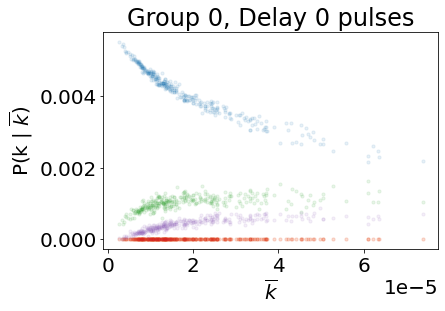

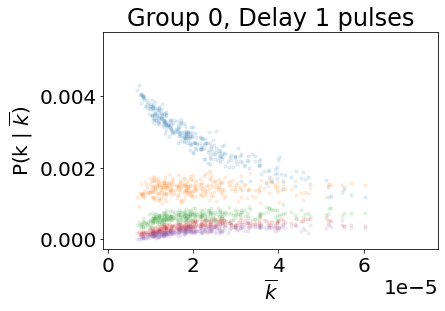

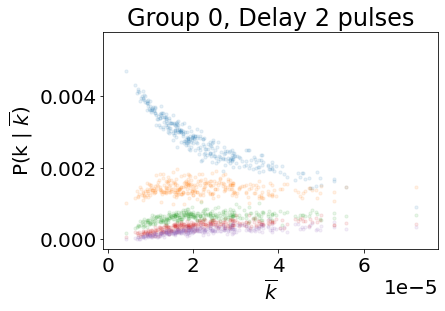

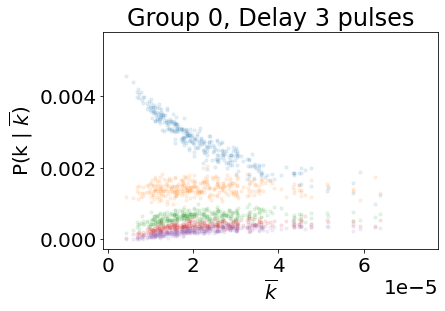

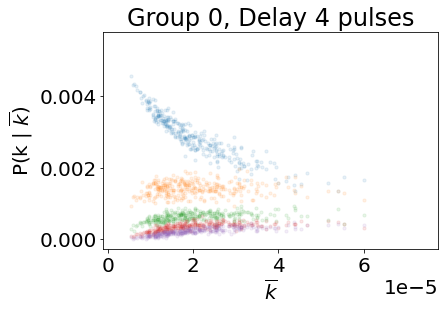

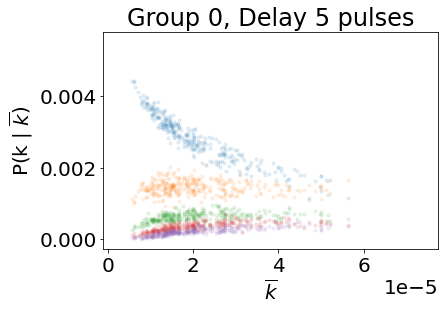

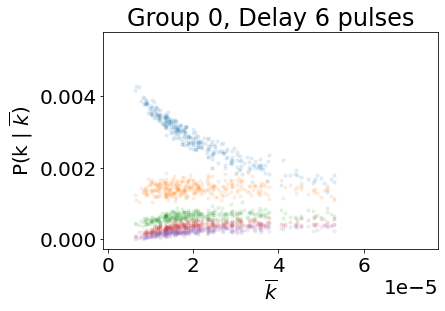

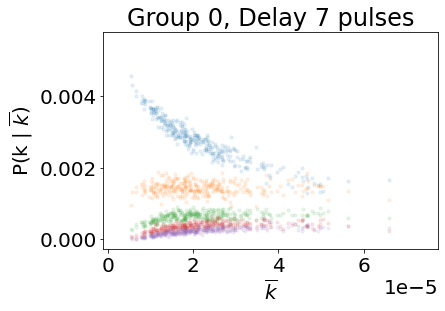

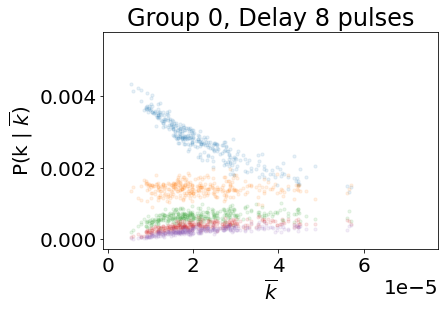

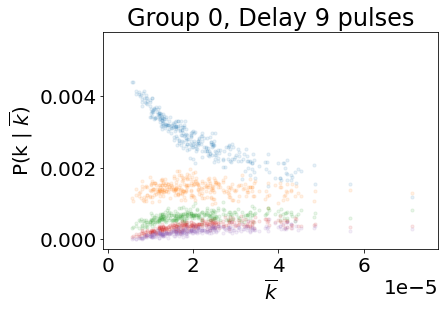

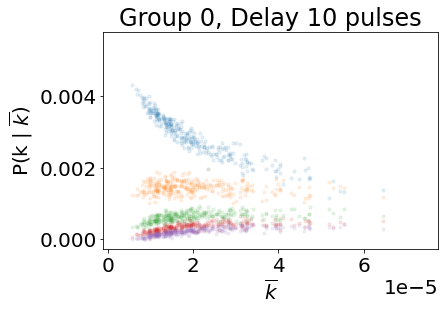

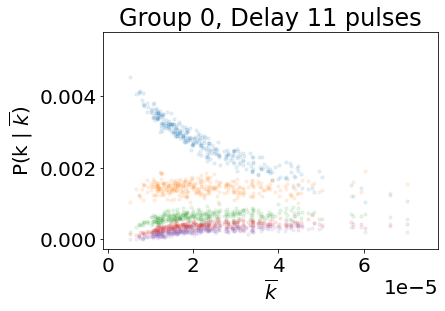

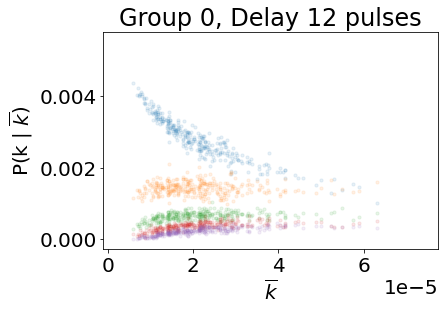

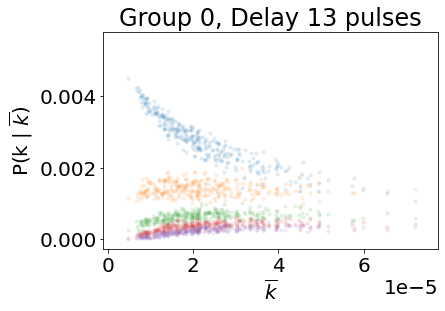

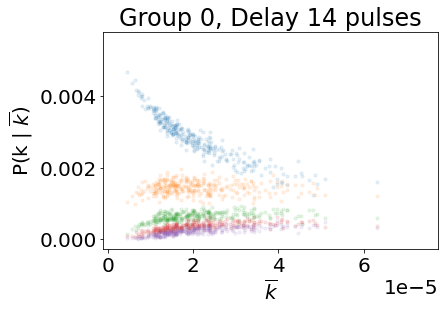

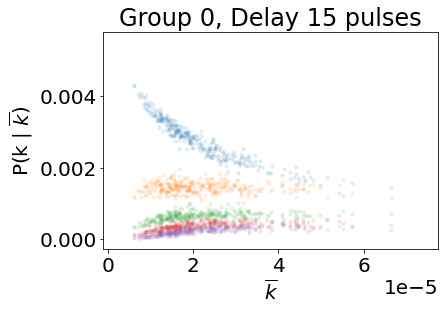

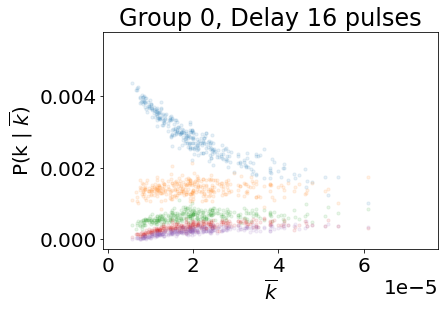

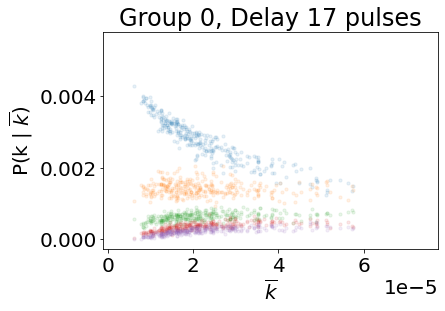

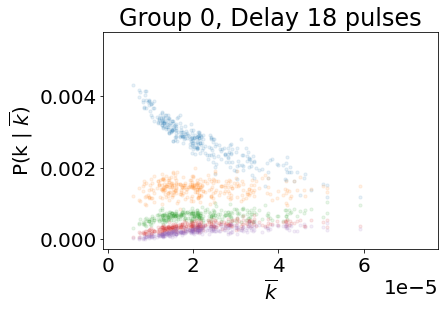

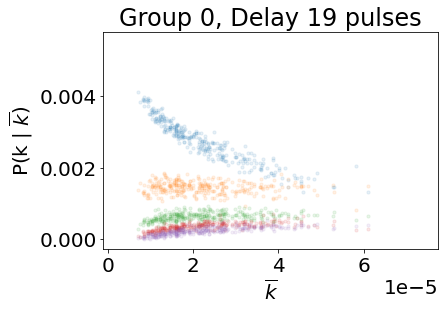

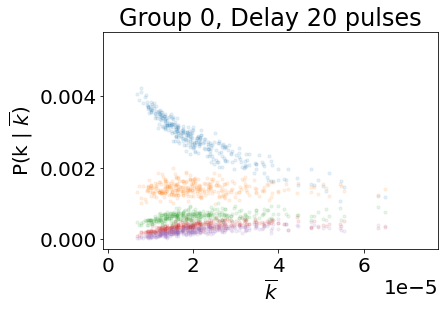

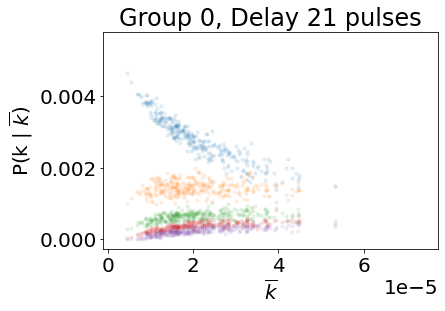

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3551246/528556086.py", line 29, in <cell line: 7>
    plt.show()
  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/matplotlib/pyplot.py", line 389, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py", line 41, in show
    display(
  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/IPython/core/display.py", line 320, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/IPython/core/formatters.py", line 

TypeError: object of type 'NoneType' has no len()

In [61]:
labels, _ = load_labels(module)
unique_labels, counts = np.unique(labels, return_counts=True)
num_pixels = counts.compute()

train_id = 0
label = 10
for dt in range(200): 
    # whole group
    t0 = time()
    y = ds['probabilities'][:, dt, label].data
    x = np.sum(np.expand_dims(np.arange(y.shape[1]), axis=0) * y, axis=1) / num_pixels[label]
    t1 = time()
    
    plt.figure()
    plt.ylabel(r'P(k | $\overline{k}$)')
    plt.xlabel(r'$\overline{k}$')
    plt.title(f'Group {0}, Delay {dt} pulses')
    for uk in range(5):
        y_ = y[:, uk]
        plt.scatter(x, y_, c=f'C{uk:0d}', alpha=0.1, s=10, label=f'k={uk:0d} photons')    

    if dt == 0:
        xlims = plt.gca().get_xlim()
        ylims = plt.gca().get_ylim()

    plt.gca().set_xlim(xlims)
    plt.gca().set_ylim(ylims)
    #plt.legend(loc='upper right', fontsize=14)
    plt.show()

In [257]:
out.shape

(300, 200, 38, 20)